In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
from typing import Tuple, List, Dict

import os
import gc
from collections import namedtuple

import numpy as np

# non so perche devo importare cdist da scipy prima di halex e non lo voglio sapere
# se non lo faccio, su newtimes ****** non funziona
# in qualunque altro posto si
from scipy.spatial.distance import cdist

import torch
import equistore

from halex.utils import tensormap_as_torch, shift_structure_by_n, drop_target_samples
from halex.rotations import ClebschGordanReal
from halex.hamiltonian import (
    compute_ham_features,
    drop_unused_features,
)
from halex.decomposition import EquivariantPCA
from halex.dataset import SCFData, BatchedMemoryDataset
from halex.models import RidgeOnEnergiesAndLowdinMultipleMolecules

from halex.train_utils import load_molecule_scf_datasets, compute_features, load_batched_dataset, coupled_fock_matrix_from_multiple_molecules

torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

Original error:
No module named 'skmatter'


In [3]:
ROOT_DIR = "/scratch/suman/"

In [4]:
def load_molecule_datasets(mol: str, cg: ClebschGordanReal, indices: np.ndarray):
    """
    Load the SCFData objects storing data for a single molecule,
    in both a small basis and a big basis
    """
    coords_path = os.path.join(
        ROOT_DIR, f"CH-dataset/{mol}/coords_{mol}_1000.xyz"
    )
    small_basis_path = os.path.join(
        ROOT_DIR, f"CH-dataset/{mol}/b3lyp_STO-3G/"
    )
    big_basis_path = os.path.join(
        ROOT_DIR,
        f"CH-dataset/{mol}/b3lyp_def2tzvp/",
    )

    sb_data, bb_data = load_molecule_scf_datasets(
        coords_path=coords_path,
        small_basis_path=small_basis_path,
        big_basis_path=big_basis_path,
        cg=cg,
        train_indices=indices,
    )

    return sb_data, bb_data

In [5]:
def dataset_for_a_single_molecule(scf_datasets, nelec_dict):
    small_basis, big_basis = scf_datasets

    frames = small_basis.frames
    # truncate the big basis MO energies to the first n_small
    mo_energy = big_basis.mo_energy[:, : small_basis.mo_energy.shape[1]]
    # no need to truncate here as they refer to _occupied_ MOs
    lowdin_charges = big_basis.lowdin_charges
    lowdin_charges_bymo = big_basis.lowdin_charges_byMO
    # orbitals in the small basis (because we predict a small basis Fock)
    orbs = small_basis.orbs
    # ao labels in the small basis
    ao_labels = small_basis.ao_labels
    # baseline fock
    baseline_focks = small_basis.focks_orth
    
    dataset = namedtuple(
        'Dataset',
        field_names='frames mo_energy lowdin_charges lowdin_charges_bymo orbs ao_labels nelec_dict baseline_focks'.split(),
        defaults=[frames, mo_energy, lowdin_charges, lowdin_charges_bymo, orbs, ao_labels, nelec_dict, baseline_focks],
    )()
    
    return dataset

In [6]:
cg = ClebschGordanReal(4)

In [7]:
molecules = [
    "ethane",
    "ethene",
    # "butadiene",
    # "hexane",
    # "hexatriene",
    # "isoprene",
    # "styrene",
]

In [8]:
train_indices = np.load('train_output/train_indices.npy')
all_indices = np.arange(1000)
test_indices = np.setdiff1d(all_indices, train_indices)[:100] #[:40]
train_indices = train_indices[:1] # only one as we don't need them now

In [9]:
# Get datasets in small and big basis
train_datasets = {
    mol: load_molecule_datasets(mol, cg=cg, indices=train_indices) # only one frame, used just to instantiate the model
    for mol in molecules
}

test_datasets = {
    mol: load_molecule_datasets(mol, cg=cg, indices=test_indices)
    for mol in molecules
}

In [10]:
# ==================================================================
# Compute the Features
# ==================================================================

# compute features
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 4,
    "gaussian_sigma_constant": 0.2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients": False,
}

epca = EquivariantPCA(n_components=200).load("train_output/epca.npz")

train_feats = compute_features(train_datasets, rascal_hypers=rascal_hypers, cg=cg, lcut=2, epca=epca)

test_feats = compute_features(test_datasets, rascal_hypers=rascal_hypers, cg=cg, lcut=2, epca=epca)

gc.collect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.68s/it]


16518

In [11]:
nelec_dict = {"H": 1.0, "C": 6.0}

train_targ_coupled = coupled_fock_matrix_from_multiple_molecules(train_datasets.values())

In [12]:
tr_datasets = {
    mol: dataset_for_a_single_molecule(train_datasets[mol], nelec_dict)
    for i, mol in enumerate(molecules)
}

te_datasets = {
    mol: dataset_for_a_single_molecule(test_datasets[mol], nelec_dict)
    for i, mol in enumerate(molecules)
}

In [13]:
model = RidgeOnEnergiesAndLowdinMultipleMolecules(
    coupled_tmap=train_targ_coupled,
    features=equistore.join(train_feats, axis='samples'),
    alpha=1e-16,
    bias=False,
)

path = os.path.join(
    "train_output/model_state_dict.pth",
)

model.load_state_dict(
    torch.load(path)
)

<All keys matched successfully>

In [14]:
from halex.popan import batched_orthogonal_lowdin_population, batched_orthogonal_lowdinbyMO_population
from halex.hamiltonian import blocks_to_dense, decouple_blocks

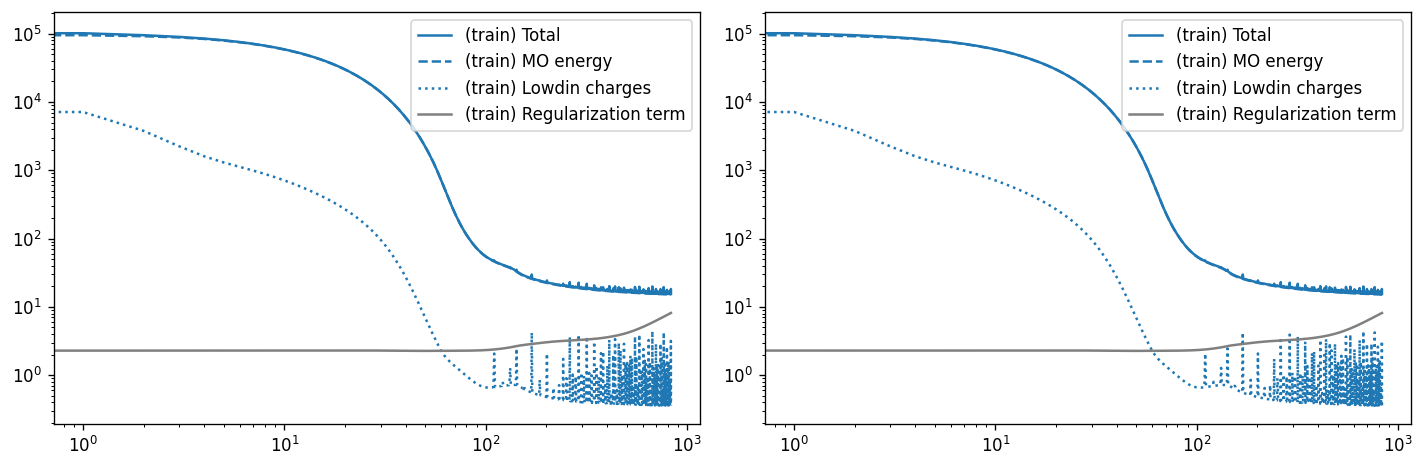

In [15]:
history = np.load("train_output/history.npz")

fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 4), dpi=120)

ax = axes[0]
kind = 'train'
c = 'C0'
ax.loglog(history[f'{kind}_total'], label=f'({kind}) Total', c=c)
ax.loglog(history[f'{kind}_eig_loss'] * 1.51e6, label=f'({kind}) MO energy', c=c, ls='--')
ax.loglog(history[f'{kind}_low_loss'] * 1e6, label=f'({kind}) Lowdin charges', c=c, ls=':')
ax.loglog(history[f'{kind}_reg_loss'] * 1e6, label=f'({kind}) Regularization term', c='gray')
ax.legend()


# kind = 'valid'
# c='C1'
# ax.loglog(history[f'{kind}_total'], label=f'({kind}) Total', c=c)
# ax.loglog(history[f'{kind}_eig_loss'] * 1.51e6, label=f'({kind}) MO energy', c=c, ls='--')
# ax.loglog(history[f'{kind}_low_loss'] * 1e6, label=f'({kind}) Lowdin charges', c=c, ls=':')
# ax.legend()

ax = axes[1]
kind = 'train'
c = 'C0'
ax.loglog(history[f'{kind}_total'], label=f'({kind}) Total', c=c)
ax.loglog(history[f'{kind}_eig_loss'] * 1.51e6, label=f'({kind}) MO energy', c=c, ls='--')
ax.loglog(history[f'{kind}_low_loss'] * 1e6, label=f'({kind}) Lowdin charges', c=c, ls=':')
ax.loglog(history[f'{kind}_reg_loss'] * 1e6, label=f'({kind}) Regularization term', c='gray')
ax.legend()


# kind = 'valid'
# c='C1'
# ax.loglog(history[f'{kind}_total'], label=f'({kind}) Total', c=c)
# ax.loglog(history[f'{kind}_eig_loss'] * 1.51e6, label=f'({kind}) MO energy', c=c, ls='--')
# ax.loglog(history[f'{kind}_low_loss'] * 1e6, label=f'({kind}) Lowdin charges', c=c, ls=':')
# ax.legend()
# ax.set_xlim(100,)
# ax.set_ylim(1e0, 1e4)

fig.tight_layout()

In [16]:
def predict(model, dataset, features, core_features=None):
    
    frames = dataset.frames
    orbs = dataset.orbs
    nelec_dict = dataset.nelec_dict
    ao_labels = dataset.ao_labels
    
    focks_orth = blocks_to_dense(decouple_blocks(model(features, core_features), cg), frames, orbs, vectorized=True)
    # focks_orth = dataset.baseline_focks + delta_focks_orth
    mo_energy, mo_coeff_orth = torch.linalg.eigh(focks_orth)
    lowdin_charges, _ = batched_orthogonal_lowdin_population(focks_orth, nelec_dict, ao_labels)
    lowdin_charges_bymo, _ = batched_orthogonal_lowdinbyMO_population(focks_orth, nelec_dict, ao_labels)
    
    prediction = namedtuple(
        'Prediction',
        field_names='focks_orth mo_energy mo_coeff_orth lowdin_charges lowdin_charges_bymo'.split(),
        defaults=[focks_orth, mo_energy, mo_coeff_orth, lowdin_charges, lowdin_charges_bymo],
    )()
    
    return prediction

In [17]:
pred_train = {
    mol: predict(model, tr_datasets[mol], train_feats[i])
    for i, mol in enumerate(tr_datasets.keys())
}

In [18]:
pred_test = {
    mol: predict(model, te_datasets[mol], test_feats[i])
    for i, mol in enumerate(te_datasets.keys())
}

In [19]:
from ase.units import Hartree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from halex.pyplot import set_equalaxes

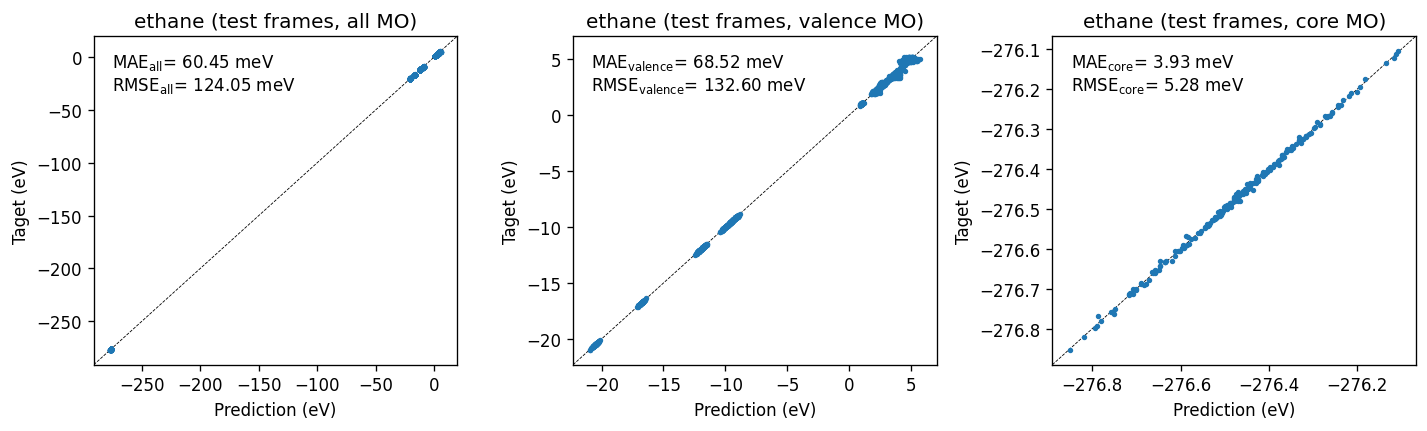

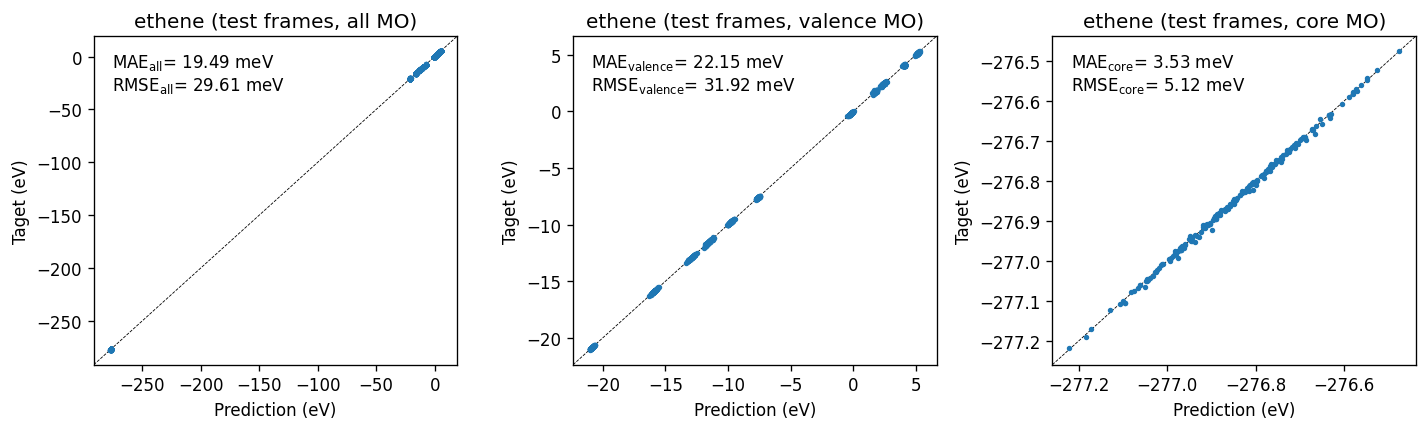

In [20]:
for mol in pred_test.keys():
    fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 3.7), dpi=120)
    
    ax = axes[0]
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    y = te_datasets[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    mae = mean_absolute_error(x, y) * 1e3
    rmse = mean_squared_error(x, y) ** 0.5 * 1e3
    ax.scatter(x, y, s=5)
    ax.text(0.05, 0.95, r'MAE$_{\rm all}$' + f'= {mae:.2f} meV\n' + r'RMSE$_{\rm all}$' + f'= {rmse:.2f} meV', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol} (test frames, all MO)')
    ax.set_xlabel('Prediction (eV)')
    ax.set_ylabel('Taget (eV)')
    set_equalaxes(ax)
    
    ax = axes[1]
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    y = te_datasets[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    x = x[x>-50]
    y = y[y>-50]
    mae = mean_absolute_error(x, y) * 1e3
    rmse = mean_squared_error(x, y) ** 0.5 * 1e3
    ax.scatter(x, y, s=5)
    ax.text(0.05, 0.95, r'MAE$_{\rm valence}$' + f'= {mae:.2f} meV\n' + r'RMSE$_{\rm valence}$' + f'= {rmse:.2f} meV', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol} (test frames, valence MO)')
    ax.set_xlabel('Prediction (eV)')
    ax.set_ylabel('Taget (eV)')
    set_equalaxes(ax)
    
    ax = axes[2]
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    y = te_datasets[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    x = x[x<-50]
    y = y[y<-50]
    mae = mean_absolute_error(x, y) * 1e3
    rmse = mean_squared_error(x, y) ** 0.5 * 1e3
    ax.scatter(x, y, s=5)
    ax.text(0.05, 0.95, r'MAE$_{\rm core}$' + f'= {mae:.2f} meV\n' + r'RMSE$_{\rm core}$' + f'= {rmse:.2f} meV', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol} (test frames, core MO)')
    ax.set_xlabel('Prediction (eV)')
    ax.set_ylabel('Taget (eV)')
    set_equalaxes(ax)
   
    fig.tight_layout()

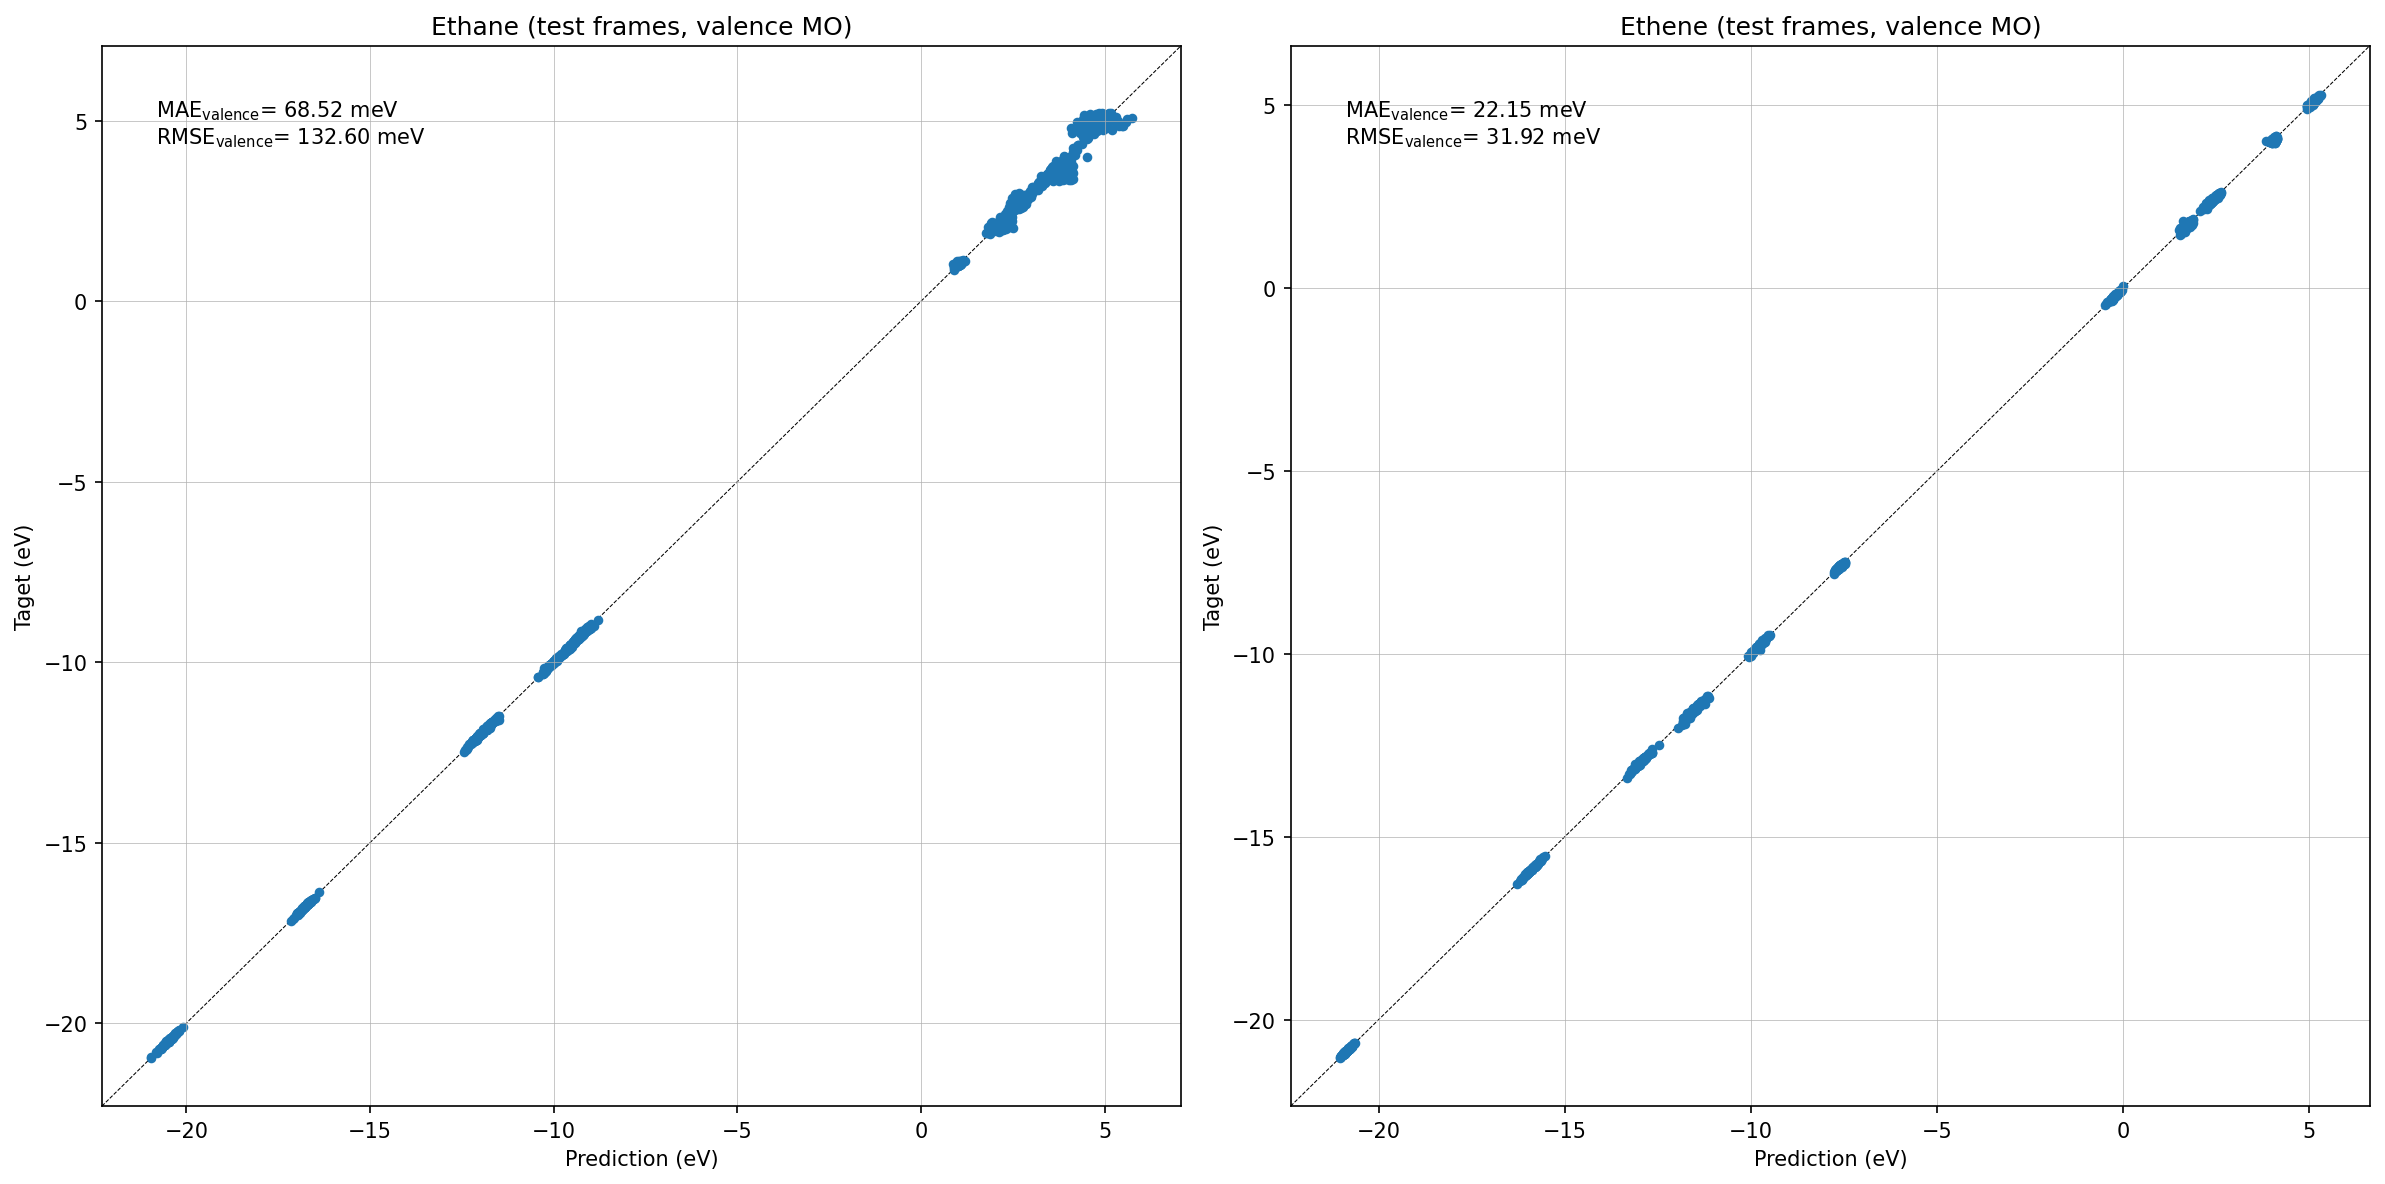

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(4*4, 4*2), dpi=150)

for ax, mol in zip(axes.flat, pred_test.keys()):
    ax.grid(lw=.33)
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    y = te_datasets[mol].mo_energy.detach().numpy().reshape(-1) * Hartree
    x = x[x>-50]
    y = y[y>-50]
    mae = mean_absolute_error(x, y) * 1e3
    rmse = mean_squared_error(x, y) ** 0.5 * 1e3
    ax.scatter(x, y, s=13)
    ax.text(0.05, 0.95, r'MAE$_{\rm valence}$' + f'= {mae:.2f} meV\n' + r'RMSE$_{\rm valence}$' + f'= {rmse:.2f} meV', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol.capitalize()} (test frames, valence MO)')
    ax.set_xlabel('Prediction (eV)')
    ax.set_ylabel('Taget (eV)')
    set_equalaxes(ax)
    
#axes[-1][-1].axis('off')

fig.tight_layout()

# Lowdin charges

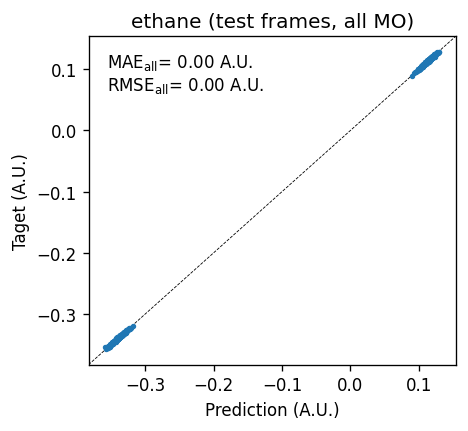

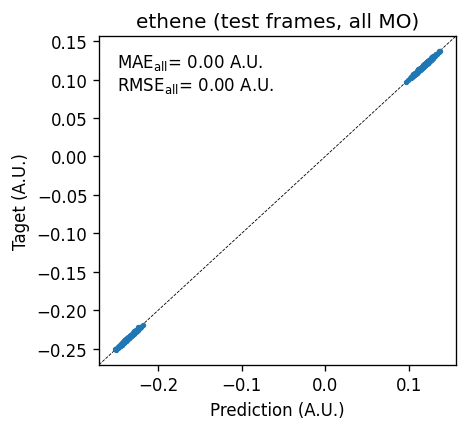

In [22]:
for mol in pred_test.keys():
    fig, ax = plt.subplots(1, 1, figsize=(4 * 1, 3.7), dpi=120)
    
    ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='k', zorder=-99, lw=.5)
    x = pred_test[mol].lowdin_charges.detach().numpy().reshape(-1)
    y = te_datasets[mol].lowdin_charges.detach().numpy().reshape(-1)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y) ** 0.5 
    ax.scatter(x, y, s=5)
    ax.text(0.05, 0.95, r'MAE$_{\rm all}$' + f'= {mae:.2f} A.U.\n' + r'RMSE$_{\rm all}$' + f'= {rmse:.2f} A.U.', ha='left', va='top', transform=ax.transAxes)
    ax.set_title(f'{mol} (test frames, all MO)')
    ax.set_xlabel('Prediction (A.U.)')
    ax.set_ylabel('Taget (A.U.)')
    set_equalaxes(ax)
   
    fig.tight_layout()

# sTDA excitation energies

In [35]:
from stda_torch.stda import sTDA
from tqdm import tqdm
import warnings

In [36]:
def compute_excitations_with_stda(scf_data, mo_energy, mo_coeff_orth):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        excen = torch.stack([
            sTDA(
                mo_energy=_mo_energy,
                mo_coeff=_mo_coeff_orth,
                mo_occ=scf_data.mo_occ,
                ovlp=None,
                natm=scf_data.natm,
                ao_labels=scf_data.ao_labels,
                coords=torch.from_numpy(_frame.positions),
                atom_pure_symbols=scf_data.atom_pure_symbols,
                ax=0.2,
                alpha=None,
                beta=None,
                e_max=20.0,
                tp=1e-4,
                mo_orth=True,
                verbose=False,
                logfile=None,
            ).kernel()
            for _mo_energy, _mo_coeff_orth, _frame
            in tqdm(zip(
                mo_energy,
                mo_coeff_orth,
                scf_data.frames,
            ))
        ])
    
    return excen

In [37]:
excens = {}
for mol, (data_sb, data_bb) in test_datasets.items():
    excens_target = compute_excitations_with_stda(data_bb, data_bb.mo_energy, data_bb.mo_coeff_orth)
    excens_predicted = compute_excitations_with_stda(data_sb, pred_test[mol].mo_energy, pred_test[mol].mo_coeff_orth)
    excens[mol] = (excens_predicted, excens_target)

100it [00:02, 49.72it/s]
100it [00:00, 164.90it/s]
100it [00:01, 90.14it/s]
100it [00:00, 259.70it/s]
100it [00:03, 31.11it/s]
100it [00:00, 145.88it/s]
100it [00:20,  4.95it/s]
100it [00:04, 24.31it/s]
100it [00:12,  7.92it/s]
100it [00:01, 90.33it/s]
100it [00:06, 14.59it/s]
100it [00:00, 100.59it/s]
100it [00:27,  3.59it/s]
100it [00:01, 54.38it/s]


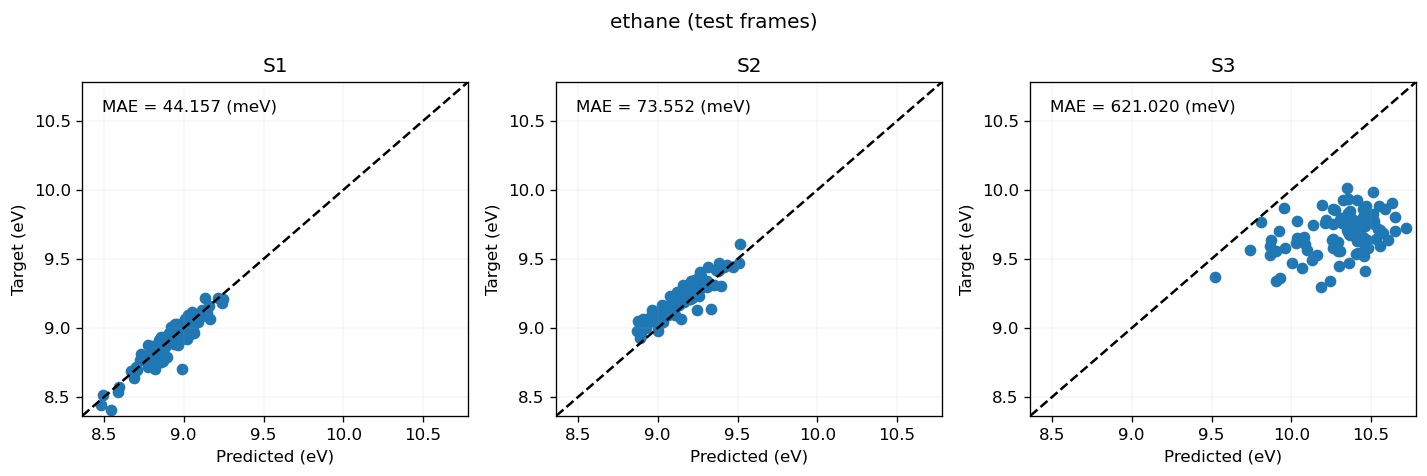

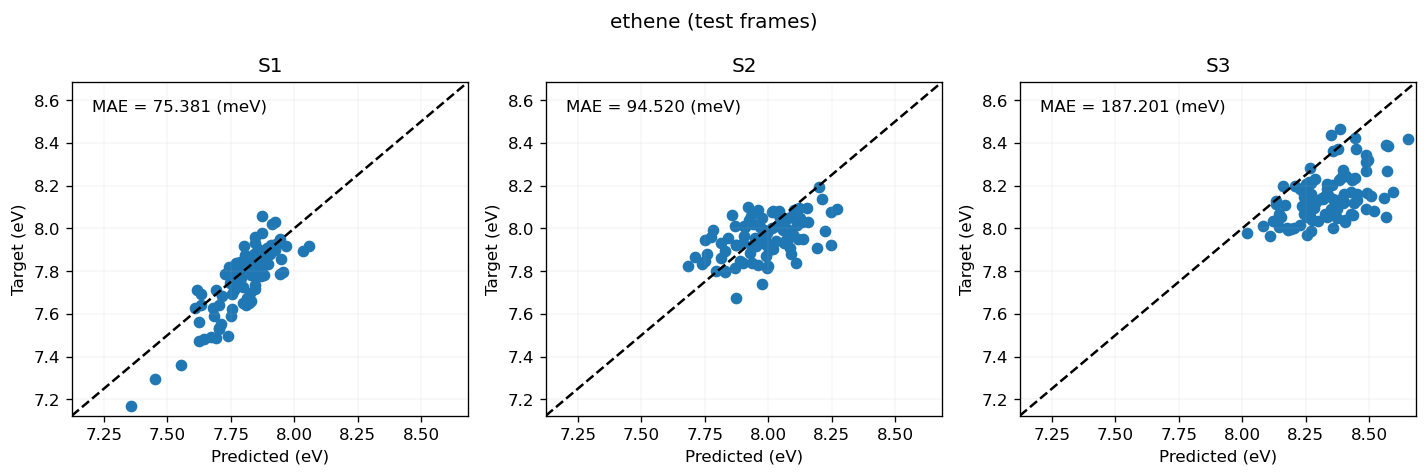

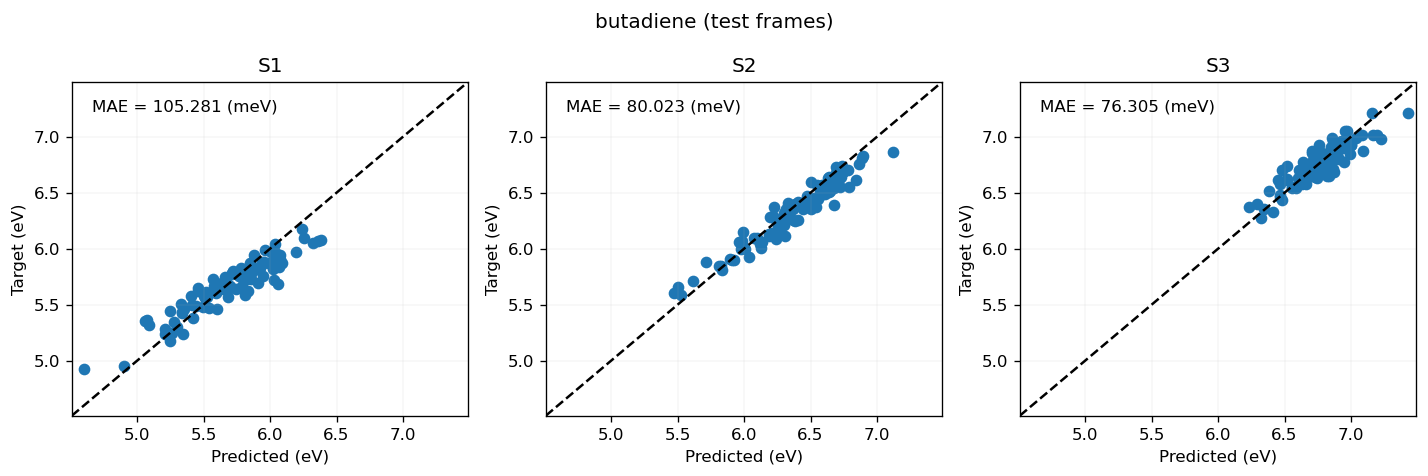

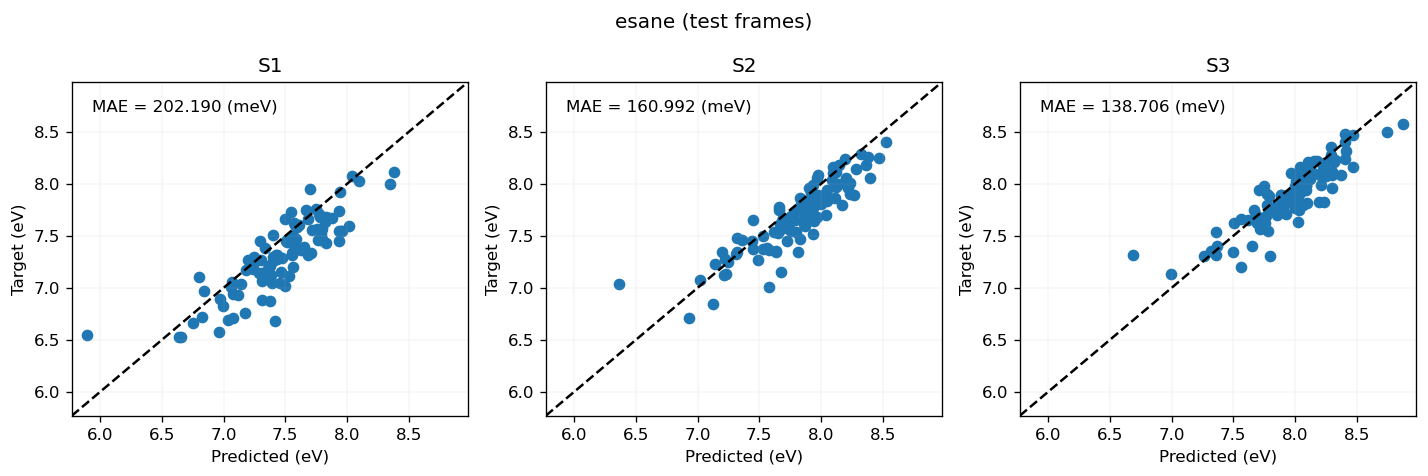

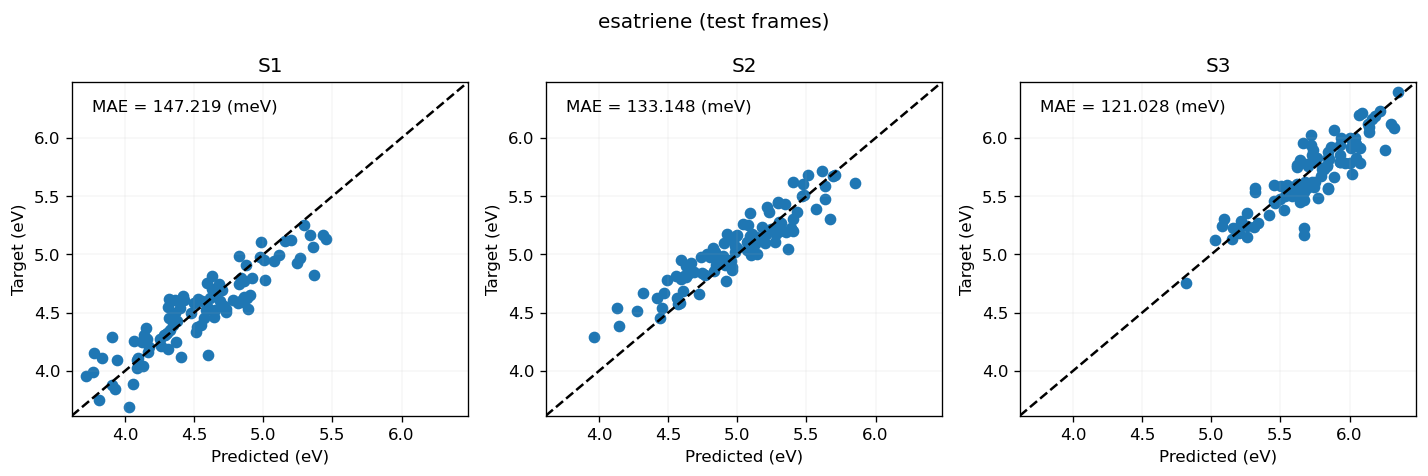

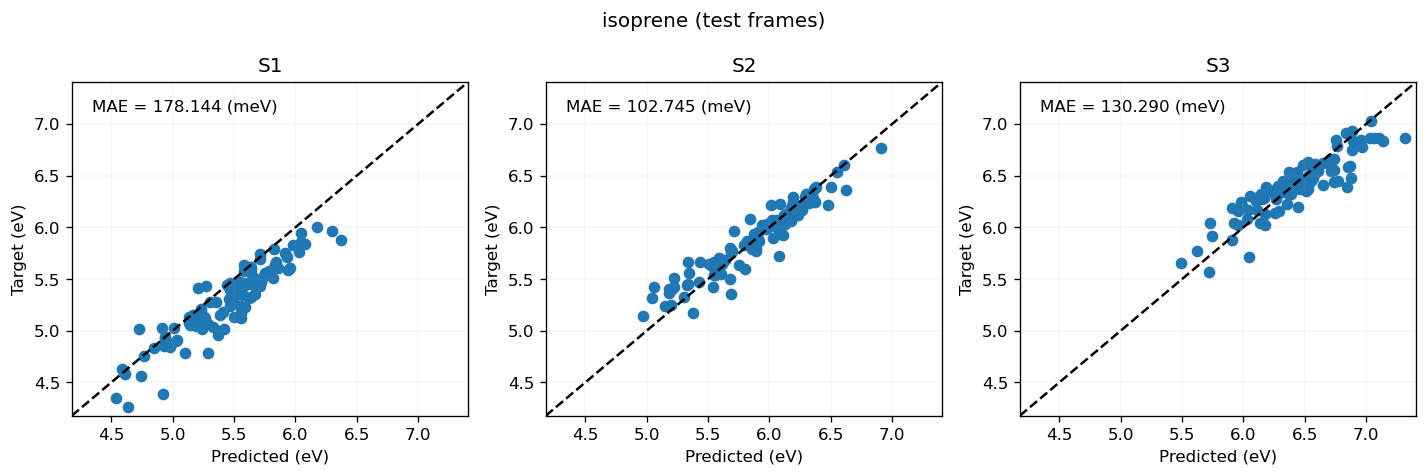

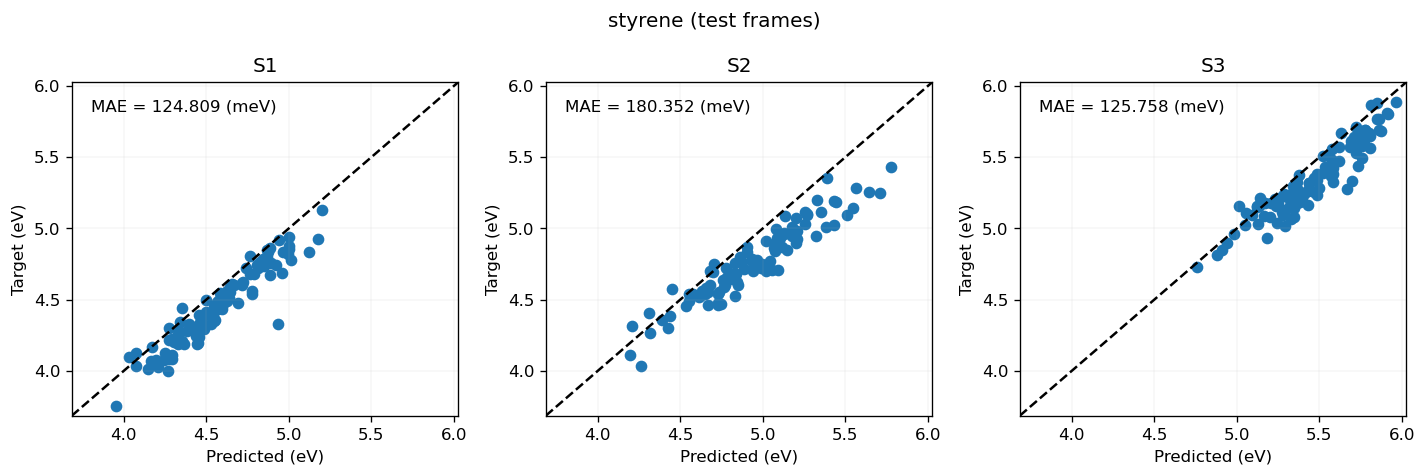

In [38]:
for mol, (pred, targ) in excens.items():
    
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4), dpi=120)
    fig.suptitle(f'{mol} (test frames)')
    
    for i, ax in enumerate(axes):
        ax.grid(lw=.1)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='dashed', c='k')
        ax.set_xlabel('Predicted (eV)')
        ax.set_ylabel('Target (eV)')
        x = pred[:, i].detach().numpy() * Hartree
        y = targ[:, i].detach().numpy() * Hartree
        mae = mean_absolute_error(x, y)
        ax.scatter(x, y)
        ax.set_title(f'S{i+1}')
        ax.text(0.05, 0.95, f'MAE = {mae*1e3:.3f} (meV)', transform=ax.transAxes, ha='left', va='top')
        
    set_equalaxes(axes)
    
    fig.tight_layout()

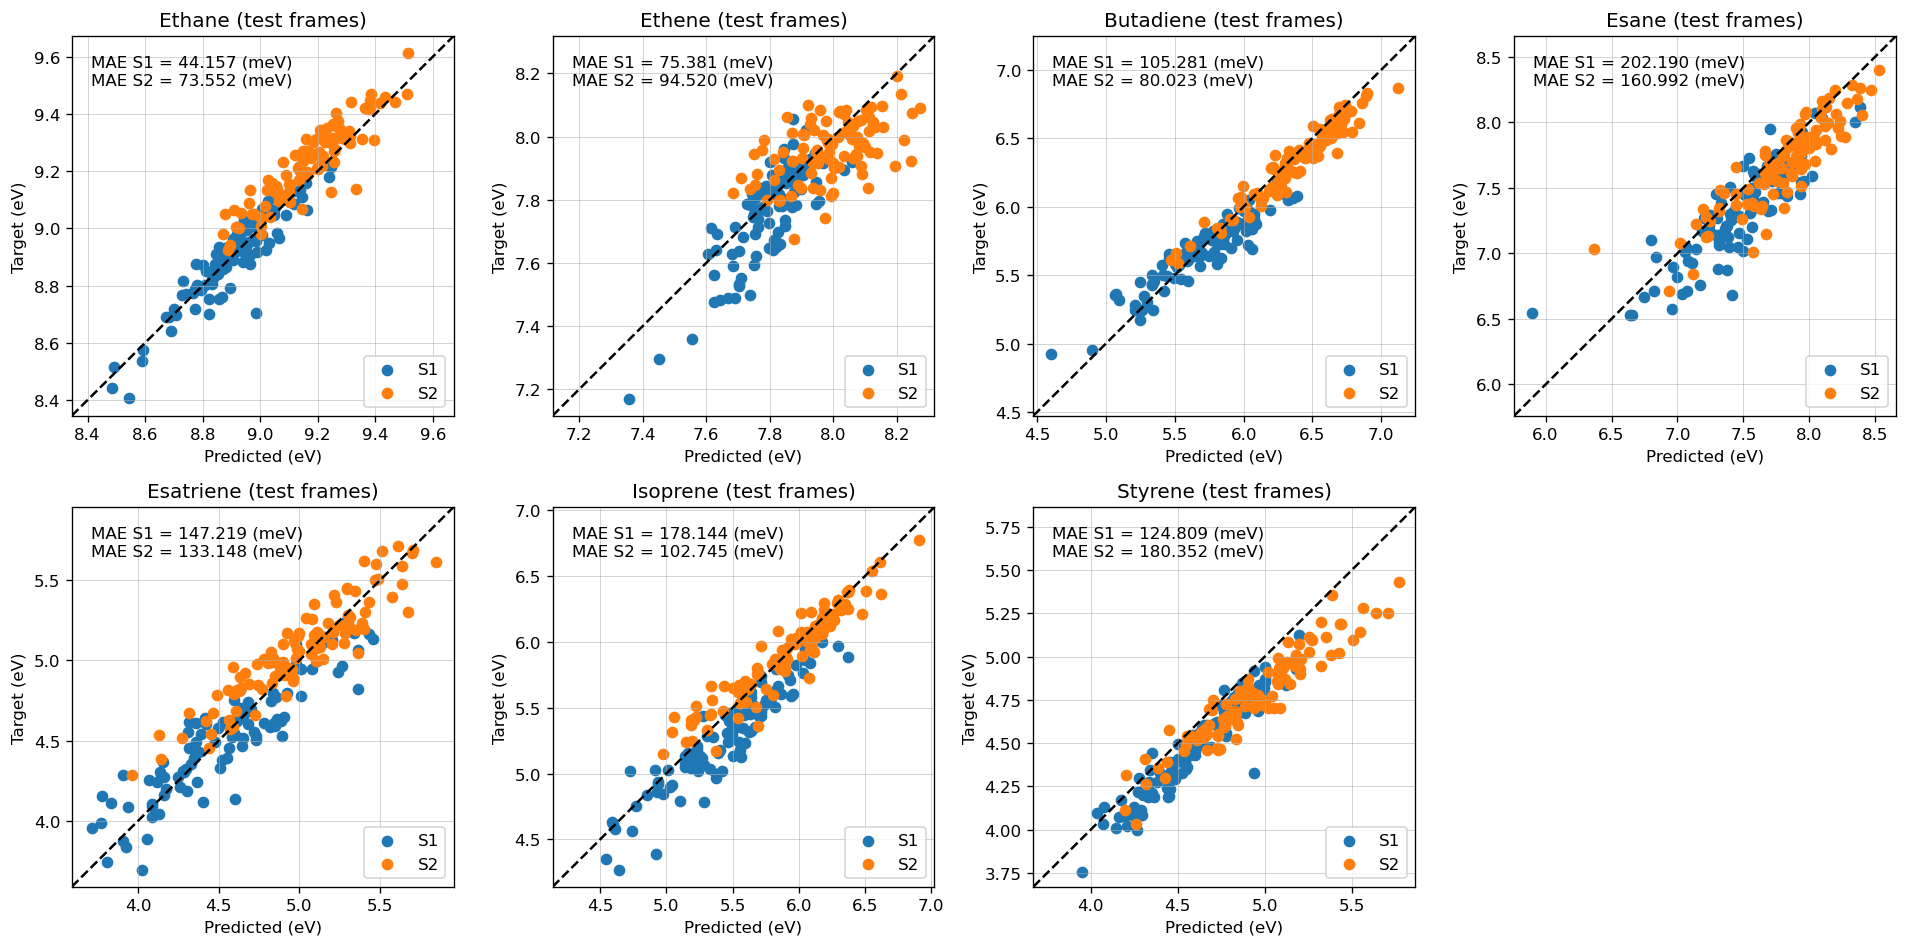

In [53]:
fig, axes = plt.subplots(2, 4, figsize=(4*4, 4*2), dpi=120)

for ax, (mol, (pred, targ)) in zip(axes.flat, excens.items()):
    ax.grid(lw=.33)
    ax.set_title(f'{mol.capitalize()} (test frames)')

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='dashed', c='k')
    ax.set_xlabel('Predicted (eV)')
    ax.set_ylabel('Target (eV)')
    errstr = ''
    for i in range(2):
        x = pred[:, i].detach().numpy() * Hartree
        y = targ[:, i].detach().numpy() * Hartree
        mae = mean_absolute_error(x, y)
        ax.scatter(x, y, label=f'S{i+1}')
        errstr += f'MAE S{i+1} = {mae*1e3:.3f} (meV)\n'
    ax.text(0.05, 0.95, errstr, transform=ax.transAxes, ha='left', va='top')
    set_equalaxes(ax)
    ax.legend(loc='lower right')

axes[-1][-1].axis('off')
fig.tight_layout()

fig.savefig('images/excens.png', dpi=200, bbox_inches='tight')

# HOMO - LUMO gap

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

ax.grid(lw=.33)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='k', ls='dashed')

errstr = ''

for i, mol in enumerate('ethene butadiene esatriene'.split()):
    
    homo = sum(train_datasets[mol][0].mo_occ == 2) - 1
    x = (pred_train[mol].mo_energy[:, homo+1] - pred_train[mol].mo_energy[:, homo]).detach().numpy().copy() * Hartree
    y = (train_datasets[mol][1].mo_energy[:, homo+1] - train_datasets[mol][1].mo_energy[:, homo]).detach().numpy().copy() * Hartree
    mse = np.mean(y - x) * 1e3 # meV
    
    ax.scatter(x, y, label=mol.capitalize(), ec='k', lw=.5)
    errstr += f'MSE({mol}) = {mse:.1f} (meV)\n'
    
ax.text(0.05, 0.95, errstr, transform=ax.transAxes, ha='left', va='top')

set_equalaxes(ax)
ax.set_ylabel('Target (eV)')
ax.set_xlabel('Predicted (eV)')
ax.set_title('HOMO - LUMO gap (train frames)')
ax.legend(loc='lower right')

fig.tight_layout()

In [ ]:
def bla(atoms, indices_db, indices_sb):
    values = []
    for atom in atoms:
        lengths_db = np.mean(np.sum(np.diff(atom.positions[indices_db], axis=1)[:, 0]**2, axis=-1)**0.5)
        lengths_sb = np.mean(np.sum(np.diff(atom.positions[indices_sb], axis=1)[:, 0]**2, axis=-1)**0.5)
        values.append(lengths_sb - lengths_db)
    return np.array(values)

In [ ]:
test_datasets['butadiene'][0].frames[0].numbers

bond_indices = {}
bond_indices['butadiene'] = (
    np.array([[0, 1], [2, 3]]), # db
    np.array([[1, 2]]), # sb
)

bond_indices['esatriene'] = (
    np.array([[0, 1], [2, 3], [4, 5]]), # db
    np.array([[1, 2], [3, 4]]) # sb
)

blas_test = {}
blas_train = {}
for mol in 'butadiene esatriene'.split():
    blas_test[mol] = bla(test_datasets[mol][0].frames, bond_indices[mol][0], bond_indices[mol][1])
    blas_train[mol] = bla(train_datasets[mol][0].frames, bond_indices[mol][0], bond_indices[mol][1])

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

ax.grid(lw=.33)

# ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='k', ls='dashed')

# errstr = ''

for i, mol in enumerate('butadiene esatriene'.split()):
    
    homo = sum(train_datasets[mol][0].mo_occ == 2) - 1
    x = (pred_train[mol].mo_energy[:, homo+1] - pred_train[mol].mo_energy[:, homo]).detach().numpy().copy() * Hartree
    y = (train_datasets[mol][1].mo_energy[:, homo+1] - train_datasets[mol][1].mo_energy[:, homo]).detach().numpy().copy() * Hartree
    # mse = np.mean(y - x) * 1e3 # meV
    df = pd.DataFrame(np.column_stack([blas_train[mol], x-y]), columns='x y'.split())
    sns.regplot(data=df, x='x', y='y', ax=ax, line_kws=dict(lw=1))
    ax.scatter(blas_train[mol], x-y, label=mol.capitalize(), ec='k', lw=.5)
    # errstr += f'MSE({mol}) = {mse:.1f} (meV)\n'
    
# ax.text(0.05, 0.95, errstr, transform=ax.transAxes, ha='left', va='top')

# set_equalaxes(ax)
ax.set_ylabel('HOMO-LUMO Red Shift (eV)')
ax.set_xlabel('BLA $\AA$')
ax.legend(loc='lower right')
ax.set_title('train frames')
ax.set_xlim(0, 0.4)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

ax.grid(lw=.33)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='k', ls='dashed')

errstr = ''

for i, mol in enumerate('ethene butadiene esatriene'.split()):
    
    homo = sum(train_datasets[mol][0].mo_occ == 2) - 1
    x = (pred_test[mol].mo_energy[:, homo+1] - pred_test[mol].mo_energy[:, homo]).detach().numpy().copy() * Hartree
    y = (test_datasets[mol][1].mo_energy[:, homo+1] - test_datasets[mol][1].mo_energy[:, homo]).detach().numpy().copy() * Hartree
    ax.scatter(x, y, label=mol.capitalize(), ec='k', lw=.5)
    mse = np.mean(y - x) * 1e3 # meV
    errstr += f'MSE({mol}) = {mse:.1f} (meV)\n'
    
ax.text(0.05, 0.95, errstr, transform=ax.transAxes, ha='left', va='top')
    

set_equalaxes(ax)
ax.set_ylabel('Target (eV)')
ax.set_xlabel('Predicted (eV)')
ax.set_title('HOMO - LUMO gap (test frames)')
ax.legend(loc='lower right')

fig.tight_layout()

In [ ]:
def compute_excitations_with_stda(scf_data, mo_energy, mo_coeff_orth):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        excen = [
            sTDA(
                mo_energy=_mo_energy,
                mo_coeff=_mo_coeff_orth,
                mo_occ=scf_data.mo_occ,
                ovlp=None,
                natm=scf_data.natm,
                ao_labels=scf_data.ao_labels,
                coords=torch.from_numpy(_frame.positions),
                atom_pure_symbols=scf_data.atom_pure_symbols,
                ax=0.2,
                alpha=None,
                beta=None,
                e_max=20.0,
                tp=1e-4,
                mo_orth=True,
                verbose=False,
                logfile=None,
            ) #.kernel()
            for _mo_energy, _mo_coeff_orth, _frame
            in tqdm(zip(
                mo_energy,
                mo_coeff_orth,
                scf_data.frames,
            ))
        ]
    
    return excen

In [ ]:
mol = 'butadiene'

data_sb, data_bb = train_datasets[mol]
stda_target = compute_excitations_with_stda(data_bb, data_bb.mo_energy, data_bb.mo_coeff_orth)
stda_predicted = compute_excitations_with_stda(data_sb, pred_train[mol].mo_energy, pred_train[mol].mo_coeff_orth)

In [ ]:
idx = 0

print('Target')
stda_target[idx].verbose = False
stda_target[idx].kernel()
stda_target[idx].verbose = True
stda_target[idx].excens_and_amplitudes()

print('Predicted')
stda_predicted[idx].verbose = False
stda_predicted[idx].kernel()
stda_predicted[idx].verbose = True
stda_predicted[idx].excens_and_amplitudes()

In [ ]:
# save test basic prediction
for mol in molecules:
    tosave = {k: v.detach().numpy().copy() for k, v in pred_test[mol]._asdict().items()}
    tosave['true_mo_energy'] = te_datasets[mol].mo_energy
    tosave['true_lowdin_charges'] = te_datasets[mol].lowdin_charges
    tosave['true_lowdin_charges_bymo'] = te_datasets[mol].lowdin_charges_bymo
    tosave['stda_excens'] = excens[mol][0].detach().numpy().copy()
    tosave['true_stda_excens'] = excens[mol][1].detach().numpy().copy()
    np.savez(f'/home/e.cignoni/HamiltonianLearningEPFL/Paper/data/n00_{mol}_pred.npz', **tosave)